In [1]:
import os
import glob
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.cuda.amp
import librosa
import time
import matplotlib.pyplot as plt
from numpy import random

from convlstm import ConvLSTM
from keras_preprocessing import sequence

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [2]:
import random
import torch
from torchvision import transforms
from torchvision.transforms import Lambda, Compose
from torchvision.transforms import functional as FF

class MyColorJitter(transforms.ColorJitter):
    @staticmethod
    @torch.jit.unused
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []


        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: FF.adjust_brightness(img, brightness_factor)))


        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: FF.adjust_contrast(img, contrast_factor)))


        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: FF.adjust_saturation(img, saturation_factor)))


        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: FF.adjust_hue(img, hue_factor)))


        random.shuffle(transforms)
        transform = Compose(transforms)


        return transform

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

In [4]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [5]:
param_dict = {
    'img_path': "./imgs_awb/",
    'depth_path': "./depth_imgs/",
    'audio_path': "./audio",
    'img_size' : 224,
    
    'sampling_mode': "depth", #beg_end
    'n_sample_frames': 8,
    'depth_thresh' : 500,
    
    'lr': 0.00001,
    'n_epoch': 100, 
    'batch_size': 8,
    'weight_decay': 0,
    
    'n_layers': 1,
    'n_units': 256,
    'lstm_dropout':0,
    
    'train_vgg': False,
    
    'batch_norm': True,
    'normalize': False,
    
    'dropout': True,
    'dropout_p': 0.3,
    
    'jitter': True,
    'j_brightness': 0.2, 
    'j_contrast': 0.2, 
    'j_saturation': 0.2, # 0?
    'j_hue': 0.2,  # 0?
    
    'random_crop': False,
    'flip': True,
}

In [6]:
def load_depth(path):
    
    img = Image.open(path).crop((220, 160, 444, 384))  # 224x224
    if random.random() > 0.5:
        img= img.transpose(Image.FLIP_LEFT_RIGHT)  # Like using a mirror at the center of the image
    img = img/np.max(img)  # Normalize
    img = Image.fromarray(np.uint8(img*255))  
    return img

In [7]:
def load_depth_color(path):
    
    #img = Image.open(path.replace("tiff", "png"))  # The purpose of this?
    img = Image.open(path)
    img = img.convert('RGB')
    result_awb = img.crop((180, 160, 404, 384))  # 224x224
    return result_awb   

In [8]:
def load_awb_rgb(path):
    
    img = Image.open(path)
    
    border = (108, 32, 556, 480)  # left, upper, right, lower -> 448x448
    result_awb = img.crop(border)
    result_awb = result_awb.resize((224,224))
    result_awb = result_awb.convert('RGB')
    return result_awb

In [9]:
def load_input(path):
    #### RGB ####
    tf = transforms.ToTensor()
    
    rgb_imgs = sorted_nicely(glob.glob(os.path.join(path + "/rgb_imgs", "*.png")))  # Read file names in the rgb_imgs folder
    depth_imgs = sorted_nicely(glob.glob(os.path.join(path + "/depth_imgs", "*.tiff")))  # Read file names in the depth_imgs folder
    
    if len(depth_imgs) == 0:  # If there is no depth image in the form of tiff, read the depth image in the form of png
        rgb_imgs = rgb_imgs[::12]  # Take every 12th frame
        depth_imgs = sorted_nicely(glob.glob(os.path.join(path + "/depth_imgs", "*.png")))  # Read file names in the depth_imgs folder
        depth_imgs = depth_imgs[::12]  # Take every 12th frame
    
    depth_means = []
    for d_path in depth_imgs:  # Calculate the average depth value of the depth images
        d_img = Image.open(d_path)
        d_mean = np.mean(d_img)
        depth_means.append(d_mean)
        d_img.close()
    
#     print("n_frames before: ", len(rgb_imgs))
    a = np.array(depth_means) > param_dict["depth_thresh"]  # If the average depth value is greater than the threshold, it is a true frames
    frame_idx = np.where(a == True)[0]  # Get the index of the true frames      
    n_frames = len(frame_idx)
    
    

    
    color_jitter = MyColorJitter(brightness=param_dict["j_brightness"],
                              contrast=param_dict["j_contrast"], 
                              saturation=param_dict["j_saturation"], 
                              hue=param_dict["j_hue"])

    color_transform = MyColorJitter.get_params(
        color_jitter.brightness, color_jitter.contrast, color_jitter.saturation,
        color_jitter.hue)

    segments = np.split(frame_idx, [int(n_frames / 3), int(n_frames / 3)*2])  # Split the true frame into 3 parts
    first_segment_idx = np.sort(np.random.permutation(segments[0])[:4])  # Randomly select 4 frames from the first part
    last_segment_idx = np.sort(np.random.permutation(segments[2])[:4])  # Randomly select 4 frames from the last part
    frame_idx = np.concatenate( (first_segment_idx, last_segment_idx), 0 )  # Combine the selected frames
    
    
    # 4 + 4 = 8 frames
    img_batch   = torch.stack(
        [tf(color_transform(load_awb_rgb(rgb_imgs[rim]))) for rim in frame_idx]

    )
    depthimg_batch = torch.stack(
        [tf(color_transform(load_depth(depth_imgs[dim]))) for dim in frame_idx]

    )


    inp_rgb = img_batch.unsqueeze(0)  # Add a dimension to the front for the batch size
    inp_depth = depthimg_batch.unsqueeze(0)
    #print(inp_rgb.shape, inp_depth.shape)
    
    #inp = torch.cat((img_batch, depthimg_batch), axis=1).unsqueeze(0)
    
    #### Audio ####

    wav_path = "301/301.wav"
        
    sample_rate, samples1 = wavfile.read(wav_path)

    if samples1.ndim > 1:  # If the audio is stereo (2 channels), convert it to mono (1 channel)
        mfcc = librosa.feature.mfcc(y=samples1[:,0].astype(np.float32), sr=sample_rate).T
    else:
        mfcc = librosa.feature.mfcc(y=samples1.astype(np.float32), sr=sample_rate).T

    mfcc = sequence.pad_sequences([mfcc], maxlen=3500)[0]  # If the length of the audio is less than 3500, pad it with 0; otherwise, truncate it to 3500
    mfcc = torch.Tensor(mfcc).float()        
            
    return inp_rgb, inp_depth, mfcc.unsqueeze(0)

In [10]:
class FailnetRGBD(nn.Module):
    def __init__(self):
        super(FailnetRGBD, self).__init__()  

        self.num_filters1 = 64
        self.num_filters2 = 128
        self.num_filters3 = 128
        
        self.bn1 = nn.BatchNorm2d(self.num_filters1)
        self.bn11 = nn.BatchNorm2d(self.num_filters1)

        self.bn2 = nn.BatchNorm2d(self.num_filters2)
        self.bn22 = nn.BatchNorm2d(self.num_filters2)

        self.bn3 = nn.BatchNorm2d(self.num_filters3)
        self.bn33 = nn.BatchNorm2d(self.num_filters3)
        
        #self.training = False
        

        self.conv1 = nn.Conv2d(in_channels=4, out_channels=self.num_filters1, kernel_size=3)
        self.conv11 = nn.Conv2d(in_channels=self.num_filters1, out_channels=self.num_filters1, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.relu11 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.convlstm1 = ConvLSTM(input_dim=self.num_filters1,
                hidden_dim=[self.num_filters1],
                kernel_size=(3, 3),
                num_layers=1,
                batch_first=True,
                bias=True,
                return_all_layers=False)


        self.conv2 = nn.Conv2d(in_channels=self.num_filters1, out_channels=self.num_filters2, kernel_size=3)
        self.conv22 = nn.Conv2d(in_channels=self.num_filters2, out_channels=self.num_filters2, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.relu22 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convlstm2 = ConvLSTM(input_dim=self.num_filters2,
                hidden_dim=[self.num_filters2],
                kernel_size=(3, 3),
                num_layers=1,
                batch_first=True,
                bias=True,
                return_all_layers=False)


        self.conv3 = nn.Conv2d(in_channels=self.num_filters2, out_channels=self.num_filters3, kernel_size=3)
        self.conv33 = nn.Conv2d(in_channels=self.num_filters3, out_channels=self.num_filters3, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.relu33 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convlstm3 = ConvLSTM(input_dim=self.num_filters3,
                hidden_dim=[self.num_filters3],
                kernel_size=(3, 3),
                num_layers=1,
                batch_first=True,
                bias=True,
                return_all_layers=False)
    

    def forward(self, x):                
        ### BLOCK 1 ###        
        batch_size,frame_size,channel,height,width = x.size()  # 8,4,3,224,224  -  torch.Size([1, 8, 6, 224, 224])
        x_in1 = x.view(batch_size*frame_size, channel, height, width)  # 32,3,224,224  -  torch.Size([8, 6, 224, 224])
        x = self.conv1(x_in1)  # 8,4,16,220,220
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv11(x)
        x = self.bn11(x)
        x = self.relu11(x)
        x = self.pool1(x)
        x = F.dropout(x, param_dict["dropout_p"]) #,training=self.training
        
        x = x.view(batch_size, frame_size, self.num_filters1, x.size()[-1], x.size()[-1])
        x = self.convlstm1(x)[0][0] # 8,4,16, 110, 110
        batch_size,frame_size,channel,height,width = x.size()
        x = x.view(batch_size*frame_size, channel, height, width)
        # Residual
#         x += self.ds1(x_in1[:,:,2:-2, 2:-2])        
        x_in2 = F.dropout(x, param_dict["dropout_p"])
        
        ### BLOCK 2 ###
        x = self.conv2(x_in2)
        x = self.bn2(x)
        x = self.relu2(x)
        x = F.dropout(x, param_dict["dropout_p"])

        x = self.conv22(x)
        x = self.bn22(x)
        x = self.relu22(x)
        x = self.pool2(x)
        x = F.dropout(x, param_dict["dropout_p"])
        
        x = x.view(batch_size, frame_size, self.num_filters2, x.size()[-1], x.size()[-1])
        x = self.convlstm2(x)[0][0] # 8,4, 32, 54, 54
        batch_size,frame_size,channel,height,width = x.size()
        x = x.view(batch_size*frame_size, channel, height, width)
        # Residual
#         res1 = self.ds1(x_in1[:,:,2:-2, 2:-2])
#         x += self.ds2(res1[:,:,2:-2, 2:-2])
        x_in3 = F.dropout(x, param_dict["dropout_p"])
        
        ### BLOCK 3 ###
        x = self.conv3(x_in3)
        x = self.bn3(x)
        x = self.relu3(x)
        x = F.dropout(x, param_dict["dropout_p"])

        x = self.conv33(x)
        x = self.bn33(x)
        x = self.relu33(x)
        x = self.pool3(x)
        x = F.dropout(x, param_dict["dropout_p"])
        
        x = x.view(batch_size, frame_size, self.num_filters3, x.size()[-1], x.size()[-1])
        x = self.convlstm3(x)[0][0] # 8,4, 64, 24, 24
        
        batch_size,frame_size,channel,height,width = x.size()
        x = x.view(batch_size*frame_size, channel, height, width)
#         x += self.ds3(x_in3[:,:,3:-3, 3:-3])
        x = x.view(batch_size, frame_size, self.num_filters3, x.size()[-1], x.size()[-1])
        
        x = x[:,-1,:] # get last frame features            
        x = x.view(batch_size, -1)
        return x

In [11]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (32, 20))        
        self.conv2 = nn.Conv1d(64, 64, (32, 1))                
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_2blocks(x)
        return x
    
    def conv_2blocks(self, input):
        conv_out = self.conv1(input) # conv_out.size() = (batch_size, out_channels, dim, 1)
        #print("conv_out.size() = ", conv_out.size())        
        conv_out = F.relu(conv_out)                
        conv_out = self.conv2(conv_out)    
        activation = F.relu(conv_out.squeeze(3))# activation.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(2)# maxpool_out.size() = (batch_size, out_channels)
        return max_out

In [12]:
class CnnLstm(nn.Module):
    def __init__(self):
        super(CnnLstm, self).__init__()  
        
        self.rgbd = FailnetRGBD()        
        self.audio = AudioCNN()
                
        self.HIDDEN_SIZE = 128*24*24
        self.AUDIO_SIZE = 64

        self.linear1 = nn.Linear(self.HIDDEN_SIZE + self.AUDIO_SIZE, 1024)
        self.linear2 = nn.Linear(1024, 2)
       
        if param_dict["dropout"]:
            self.dropout = nn.Dropout(p=param_dict["dropout_p"])
            self.dropout2 = nn.Dropout(p=param_dict["dropout_p"])
   
        self.mp = nn.MaxPool1d(2)
    
    def forward(self, x, x_d, x_audio):        
        
        x = torch.cat((x, x_d), axis=2)
        
        x = self.rgbd(x)
        #print("x_audio", x_audio.size())
        x_audio = self.audio(x_audio)
        x = torch.cat((x,x_audio), 1)
            
        if param_dict["dropout"]:
            x = F.relu(self.linear1(x))
            x = self.linear2(self.dropout2(x))
            return x
        else:
            return self.linear(x)

In [13]:
model = CnnLstm()
model.load_state_dict(torch.load("finonet-rgbda-pretrained.pth")["state_dict"])

<All keys matched successfully>

In [15]:
x, x_d, x_a = load_input("301")
print(x.shape, x_d.shape, x_a.shape)
out = model(x, x_d, x_a)
print(out)
# [[0.5906, 0.2103]]

/home/cosmos/mambaforge/envs/th18/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  """


torch.Size([1, 8, 3, 224, 224]) torch.Size([1, 8, 1, 224, 224]) torch.Size([1, 3500, 20])


/home/cosmos/mambaforge/envs/th18/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[0.9052, 1.0969]], grad_fn=<AddmmBackward>)


In [17]:
model.rgbd.conv33

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))

In [14]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [model.rgbd.conv33]
x_, x_d_, x_a_ = load_input("301")
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(x=x_, x_d=x_d_, x_a=x_a_, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

/home/cosmos/mambaforge/envs/th18/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  """
/home/cosmos/mambaforge/envs/th18/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TypeError: get_cam_weights() takes 6 positional arguments but 8 were given

In [21]:
len(input_tensor)

3

In [26]:
torch.max(torch.softmax(out, dim=1), 1)

torch.return_types.max(
values=tensor([0.7245], grad_fn=<MaxBackward0>),
indices=tensor([1]))

In [27]:
from captum.attr import Deconvolution, GuidedBackprop, GradientShap, Occlusion, NoiseTunnel, Saliency, GuidedGradCam
from captum.attr import visualization as viz

In [28]:
model.eval()

CnnLstm(
  (rgbd): FailnetRGBD(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn33): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (relu11): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convlstm1): ConvLSTM(
      (cell_list): ModuleList(
        (0): ConvLSTMCell(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [29]:
# https://stackoverflow.com/questions/58297197/how-to-change-activation-layer-in-pytorch-pretrained-module
def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            setattr(model, n, new)

replace_layers(model, nn.ReLU, nn.ReLU(inplace=False))

In [30]:
x, x_d, x_audio = load_input("301")
x.requires_grad_()
x_d.requires_grad_()
x_audio.requires_grad_()

/home/cosmos/mambaforge/envs/th18/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  """


tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [669.,  59., -11.,  ...,  10.,  -3.,  10.],
         [670.,  53., -16.,  ...,   7.,  -3.,  13.],
         [672.,  52., -15.,  ...,   9.,   0.,  15.]]], requires_grad=True)

In [44]:
vi = GuidedBackprop(model)
attr = vi.attribute((x, x_d, x_audio), target=0)  # 0: Attributions for the first class: 'success'; 1: 'failure'

/home/cosmos/mambaforge/envs/th18/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [18]:
x.shape

torch.Size([1, 8, 3, 224, 224])

In [52]:
y_hat = model(x, x_d, x_audio)
loss = torch.nn.functional.cross_entropy(y_hat, torch.tensor([0]))
loss.backward()
saliency = x.grad[0][0].abs().max(0)[0]  # .max(0) method returns a tuple of (values, indices)

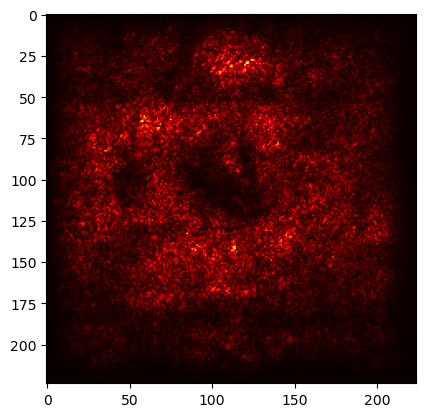

In [53]:
plt.imshow(saliency, cmap=plt.cm.hot)

In [20]:
#https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

In [21]:
for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
        print(model.named_modules())
        module.register_backward_hook(relu_hook_function)

<generator object Module.named_modules at 0x7ff5ae4429d0>
<generator object Module.named_modules at 0x7ff5ae4429d0>
<generator object Module.named_modules at 0x7ff5ae4429d0>
<generator object Module.named_modules at 0x7ff5ae4429d0>
<generator object Module.named_modules at 0x7ff5ae4429d0>
<generator object Module.named_modules at 0x7ff5ae4429d0>


In [22]:
out = model(x, x_d, x_audio)
out[0, 1].backward()
gradygrad = x.grad[0][0].abs().max(0)[0]

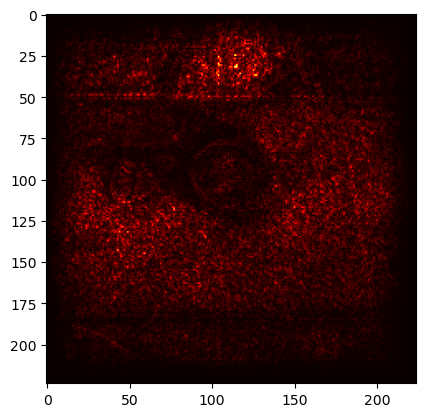

In [106]:
plt.imshow(gradygrad, cmap=plt.cm.hot)

In [108]:
out = model(x, x_d, x_audio)
out[0, 1].backward()
gradygrad = x.grad[0][0].abs().max(0)[0]

: 

: 

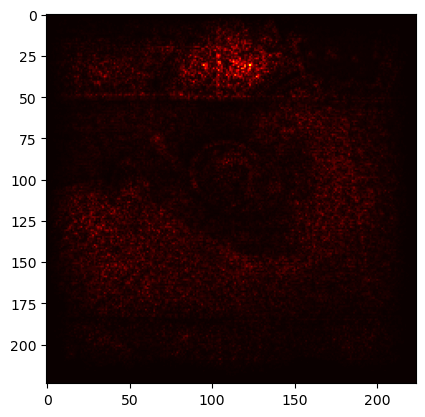

In [23]:
plt.imshow(gradygrad, cmap=plt.cm.hot)

In [36]:
attr[0].shape

torch.Size([1, 8, 3, 224, 224])

In [45]:
attr = 25*attr[0][0][0].squeeze().cpu().detach().numpy()
attr = np.transpose(attr, (1, 2, 0))  # (C, H, W) -> (H, W, C) for PIL image
attr = np.abs(attr)  # Take absolute value of gradients to enhance the visualization
attr = np.max(attr, axis=2)  # Take the maximum over the channels
attr = np.clip(attr, 0, 1)  # Clip to 0-1 range ->  [-1,0,1,2] -> [0,0,1,1]
attr = np.uint8(attr * 255)  # Scale to 0-255 range
attr = Image.fromarray(attr)
attr = attr.resize((224, 224))
attr.save("gb_0_25.png")

In [46]:
im2fmap = nn.Sequential(*(list(model.rgbd.children())[:-2]))  # Through conv33, which is the last conv layer

In [ ]:
im2fmap

In [75]:
x_audio.dim()

3

In [ ]:
x, x_d, x_audio = load_input("301")
x.requires_grad_(True)
x_d.requires_grad_(True)
x_audio.requires_grad_(True)

model.eval()
logits = model(x, x_d, x_audio)
heatmaps = []
activations = im2fmap((x, x_d, x_audio))
print(activations.shape)
pred = logits.max(-1)[-1]
# get the model's prediction
model.zero_grad()
# compute gradients with respect to model's most confident logit
logits[0,pred].backward(retain_graph=True)
# get the gradients at the required featuremap location
# and take the avg gradient for every featuremap
pooled_grads = model.rgbd.conv33.weight.grad.data.mean((1,2,3))
# multiply each activation map with corresponding gradient average
for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_grads[i]
# take the mean of all weighted activation maps
# (that has been weighted by avg. grad at each fmap)
heatmap = torch.mean(activations, dim=1)[0].cpu().detach()

In [17]:
len(attr)

3

In [22]:
attr[0].shape, attr[1].shape, attr[2].shape

(torch.Size([1, 8, 3, 224, 224]),
 torch.Size([1, 8, 1, 224, 224]),
 torch.Size([1, 3500, 20]))

In [28]:
attr1 = 25*attr[0][0][1].cpu().detach().numpy()
attr1 = np.transpose(attr1, (1, 2, 0))
attr1 = np.abs(attr1)
attr1 = np.max(attr1, axis=2)
attr1 = np.clip(attr1, 0, 1)
attr1 = np.uint8(attr1 * 255)
attr1 = Image.fromarray(attr1)
attr1 = attr1.resize((224, 224))
attr1.save("attr1_2.png")